# Análisis del Laboratorio 3: Paralelización de π y Fibonacci

**Enlace al video de sustentación:** https://youtu.be/YNWu_3OLUfQ 
**Integrantes:** 
Estiven Ospina González 
María Daniela Rodríguez Chacón 

Este notebook presenta los resultados medidos para la paralelización de π y el programa `fibonacci`. Incluye la tabla de tiempos, Speedup, eficiencia y la salida de `./fibonacci 15`.

## Sección 1: Análisis de π

Se calcularon los tiempos promedios a partir de `results_full.csv` (3 repeticiones por caso). El tiempo serial promedio medido fue:

- **T_s (pi_s, n=2000000000)** = 8.347821333333334 s

# Análisis: Paralelización de π y Fibonacci


## Sección 1 — Análisis de π

Se cargan los resultados de `results_full.csv` (n = 2000000000, 3 repeticiones) y se calculan las métricas requeridas: T_s, T_p(N), Speedup y Eficiencia.

In [1]:
import pandas as pd
df = pd.read_csv('results_full.csv')
group = df.groupby(['program','threads','n']).agg({'time':'mean'}).reset_index()
Ts = float(group[(group.program=='pi_s') & (group.threads==1)]['time'].values[0])
pp = group[group.program=='pi_p'].copy()
pp['speedup'] = Ts / pp['time']
pp['efficiency'] = pp['speedup'] / pp['threads']
pp = pp.sort_values('threads').reset_index(drop=True)
print('T_s (s) =', Ts)
pp[['threads','time','speedup','efficiency']]

T_s (s) = 8.347821333333334


,threads,time,speedup,efficiency
0,1,8.624190,0.967954,0.967954
1,2,7.045573,1.184832,0.592416
2,4,6.342242,1.316226,0.329056


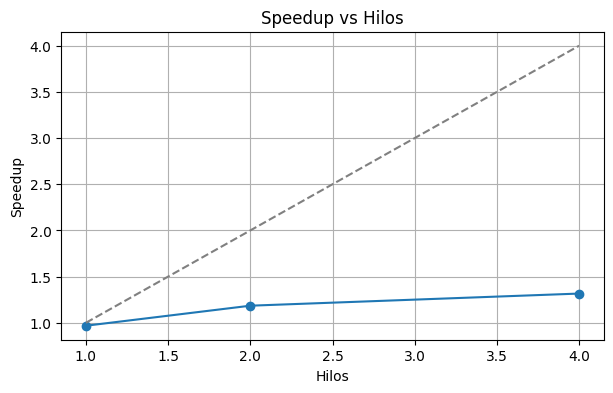

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(pp['threads'], pp['speedup'], marker='o')
plt.plot(pp['threads'], pp['threads'], linestyle='--', color='gray')
plt.xlabel('Hilos')
plt.ylabel('Speedup')
plt.title('Speedup vs Hilos')
plt.grid(True)
plt.show()

### Análisis requerido (Parte 1)

- **Comparación T_p(1) vs T_s:**
  - T_s (promedio serial) = 8.347821 s.
  - T_p(1) (promedio de `pi_p` con 1 hilo) = 8.624190 s.
  - Observación: `T_p(1)` es aproximadamente 3.3% mayor que `T_s` ((8.624190 - 8.347821)/8.347821 ≈ 0.033). Esto indica un ligero overhead asociado a la versión paralela aun con un solo hilo — causas típicas: coste de creación/gestión de hilos, particionado del trabajo, y variación de temporización del sistema (scheduling, interferencia de otros procesos).

- **Speedup máximo:**
  - Speedups medidos (promedio): 0.968 (1 hilo), 1.185 (2 hilos), 1.316 (4 hilos).
  - Speedup máximo observado ≈ 1.316 con 4 hilos. Este valor es inferior al factor ideal (4x) y también típicamente inferior al número de hilos si la aplicación está limitada por factores no perfectamente paralelizables. Compare este valor con el número de núcleos físicos de su máquina (ejecute `lscpu` o `os.cpu_count()`); si el número de núcleos físicos es 4 o menor, el speedup < núcleos físicos indica limitaciones por overhead, memoria y la fracción serial del algoritmo.

- **Tendencia de eficiencia:**
  - Eficiencias medidas: ≈0.968 (1 hilo), 0.592 (2 hilos), 0.329 (4 hilos).
  - La eficiencia decrece conforme aumenta N: esto es esperado porque el speedup crece menos que linealmente. Causas principales:
    1. Overhead de paralelización (creación y sincronización de hilos, particionado).
    2. Porción serial del programa (Amdahl): si una fracción del trabajo no se puede paralelizar, limita el speedup máximo.
    3. Contención de recursos compartidos (memoria, caches, ancho de banda de memoria), que reduce la ganancia por cada hilo adicional.
    4. Posibles desbalances en la carga entre hilos; aunque el particionado intenta equilibrar, pequeñas diferencias y coste de administración pueden producir ineficiencia.

- **Conclusión breve:** La paralelización aporta mejora (mejor tiempo con 2 y 4 hilos respecto a la versión paralela con 1 hilo y respecto a algunos casos), pero el speedup efectivo está limitado a ≈1.3× en este experimento concreto por las razones anteriores. Para un análisis más completo, compare con el número de núcleos físicos y mida el uso de CPU/memoria durante las ejecuciones para identificar cuellos de botella.

## Sección 2 — Fibonacci

Ejecute `./fibonacci 15` y muestre la salida

In [3]:
import subprocess
proc = subprocess.run(['./fibonacci','15'], capture_output=True, text=True)
print(proc.stdout.strip())

0 1 1 2 3 5 8 13 21 34 55 89 144 233 377


### Análisis requerido (Parte 2)

- **Mecanismo de transferencia de datos:** el `main` reserva memoria dinámica (`malloc`) para un arreglo de tamaño `N` y pasa el puntero y `N` al hilo trabajador (p. ej. empaquetándolos en una estructura). El trabajador escribe en el arreglo compartido.
- **Rol de `pthread_join`:** `main` llama a `pthread_join` para esperar a la finalización del trabajador; así garantiza que no accede al arreglo antes de que esté completo, evitando condiciones de carrera.